In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

In [2]:
powers_of_10_lims = (2, 4)
num_Vs_per_tile = 4
num_graphs_per_power_of_10 = 5
total_dpowers = num_graphs_per_power_of_10 * (powers_of_10_lims[1] - powers_of_10_lims[0]) + 1
power_linspace = np.linspace(powers_of_10_lims[0], powers_of_10_lims[1], total_dpowers)

tiles_per_dim = np.int32(np.sqrt(10**power_linspace / num_Vs_per_tile))

In [11]:
g = construct_graph.tiling.Tiling(tile_type='hexagonal_tile',
                                    num_horizontal_displacements=tiles_per_dim[-1],
                                    num_vertical_displacements=tiles_per_dim[-1],
                                    autoplot=False, figsize=3)

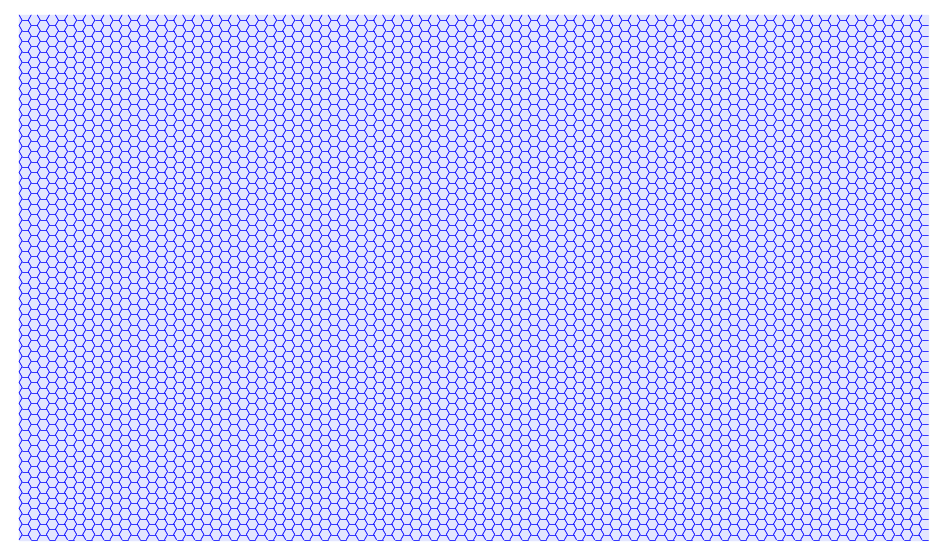

In [12]:
fig, ax = g.plot_graph(return_figax=True, linewidth=generate_graph_linewidth(g.num_Vs), embedding_space="hexagon_rectangle")
plt.savefig("tiling/hexagonal_periodic/large_hexagonal_tiling.png", dpi=200, bbox_inches="tight")


In [34]:
run_eigenvalue_calculations = True

if run_eigenvalue_calculations:
    guesses = np.concatenate([np.array([1e-15]), np.linspace(1, 20, 300)])

    eigenvalue_data = {}

    for tile_num in tiles_per_dim:
        g = construct_graph.tiling.Tiling(tile_type='hexagonal_tile',
                                          num_horizontal_displacements=tile_num,
                                          num_vertical_displacements=tile_num,
                                          autoplot=False, figsize=3)
        print(f"num_Vs = {g.num_Vs}")
        print("\n\n\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=1000, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigenvalue_data[g.num_Vs] = eigenvalues.copy()

num_Vs = 100





Calculating eig number 0

----------------------
Converged at step 0:

k = 1.049508204260907e-15
----------------------

Calculating eig number 1

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 2

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 3

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 4

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 5

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 6

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 7

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 8

----------------------
Converged at step 2:

k = 0
----------------------

Calculating eig number 9

----------------------
Conv

In [35]:
eigenvalue_data

{100: array([1.04950820e-15, 4.43447256e+00, 7.65204342e+00, 8.81046933e+00,
        1.15842266e+01, 1.30132898e+01, 1.50170646e+01, 1.54563833e+01,
        1.66826581e+01, 1.84643913e+01, 2.04494885e+01]),
 144: array([2.28429183e-15, 4.43710540e+00, 7.66548861e+00, 8.83588821e+00,
        1.16411930e+01, 1.31350978e+01, 1.51392361e+01, 1.56806198e+01,
        1.71956991e+01, 1.88081589e+01, 1.94384457e+01]),
 196: array([1.29092579e-15, 4.43866567e+00, 7.67349764e+00, 8.85011652e+00,
        1.16732733e+01, 1.31958980e+01, 1.52093565e+01, 1.57883103e+01,
        1.74047006e+01, 1.89780549e+01, 1.97908248e+01]),
 324: array([8.30888980e-16, 4.44034968e+00, 7.68217631e+00, 8.86482434e+00,
        1.17066669e+01, 1.32538323e+01, 1.52831647e+01, 1.58893524e+01,
        1.75784861e+01, 1.91433600e+01, 2.00662421e+01]),
 576: array([2.03506443e-15, 4.44146466e+00, 7.68794211e+00, 8.87421080e+00,
        1.17281348e+01, 1.32884187e+01, 1.53309772e+01, 1.59493091e+01,
        1.76717764e+01,

In [99]:
def calculate_pde_eigenvalues(m, n):
    return np.sqrt( ((2 * np.pi * m)**2 + (2 * np.pi * n * np.sqrt(3))**2) / 2 )

mn = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

In [5]:
class Eigendata:

    def __init__(self, data):

        self.data = data
        self.V_nums = np.array(list(self.data.keys()))
        self.eigendata_indices = list(self.data[self.V_nums[0]].keys())
        self.graph_eigenvalues, self.PDE_eigenvalues = self.get_eigenvalues()
        self.relative_eigenvalue_differences = self.calculate_relative_eigenvalue_differences()
        self.relative_eigenfunction_differences = self.calculate_relative_eigenfunction_differences()

    def get_eigenvalues(self):

        graph_eigenvalues = {}
        PDE_eigenvalues = {}
        for m, n in self.eigendata_indices:
            graph_eigenvalues[m, n] = []
            PDE_eigenvalues[m, n] = self.data[self.V_nums[0]][m, n]['PDE']['eigenvalue']
            for num_Vs in self.V_nums:
                graph_eigenvalues[m, n].append(self.data[num_Vs][m, n]['graph']['eigenvalue'])

        return graph_eigenvalues, PDE_eigenvalues
        
    def calculate_relative_eigenvalue_differences(self):

        relative_eigenvalue_differences = {}
        for m, n in self.eigendata_indices:
            pde_eig = self.PDE_eigenvalues[m, n]
            if np.abs(self.PDE_eigenvalues[m, n]) < 1e-14:
                rel_errs = [np.mean(np.abs(i - pde_eig)) for i in self.graph_eigenvalues[m, n]]
            else:
                rel_errs = [np.mean(np.abs((i - pde_eig) / pde_eig)) for i in self.graph_eigenvalues[m, n]]
            relative_eigenvalue_differences[m, n] = np.array(rel_errs)

        return relative_eigenvalue_differences

    def calculate_relative_eigenfunction_differences(self):

        relative_eigenfunction_differences = {}
        for m, n in self.eigendata_indices:
            relative_eigenfunction_differences[m, n] = []
            for num_Vs in self.V_nums:
                rel_errs = [(i - j).norm() for i, j in zip(self.data[num_Vs][m, n]['graph']['eigenfunction'], 
                                                           self.data[num_Vs][m, n]['PDE']['eigenfunction'])]
                relative_eigenfunction_differences[m, n].append(np.mean(rel_errs))

        return relative_eigenfunction_differences

class Graph_Modes:

    def __init__(self, g, graph_eigenvalues):

        (self.graph_eigenvalues,
         self.graph_eigenvectors, 
         self.null_space_dims) = self.calculate_graph_eigenvectors(g, graph_eigenvalues)
        self.graph_eigenfunctions = self.construct_graph_eigenfunctions(g)
    
    def construct_graph_eigenfunction(self, g, eigenvalue, eigenvector):

        graph_eigenfunction = []

        if np.abs(eigenvalue) < 1e-13:
            for e_num, ((v_num, w_num), l_vw) in enumerate(g.E_lengths_by_v_num.items()):
                edge_mode = np.ones(g.g_coords[e_num].shape[1])
                graph_eigenfunction.append(edge_mode)
        else:
            for e_num, ((v_num, w_num), l_vw) in enumerate(g.E_lengths_by_v_num.items()):
                parametrised_edge = np.linspace(0, l_vw, g.g_coords[e_num].shape[1])

                edge_mode = ((eigenvector[v_num] * np.sin(eigenvalue * parametrised_edge[::-1])
                            + eigenvector[w_num] * np.sin(eigenvalue * parametrised_edge)) 
                            / np.sin(eigenvalue * l_vw))
                
                graph_eigenfunction.append(edge_mode)

        graph_eigenfunction = Graph_Function(graph_eigenfunction, g.g_coords).normalize()

        return graph_eigenfunction
    
    def construct_graph_eigenfunctions(self, g):

        graph_eigenfunctions = []
        for eigenvalue, eigenvector in zip(self.graph_eigenvalues, self.graph_eigenvectors.T):
            graph_eigenfunctions.append(self.construct_graph_eigenfunction(g, eigenvalue, eigenvector))
        
        return graph_eigenfunctions
    
    def calculate_graph_eigenvectors(self, g, graph_eigenvalues):

        graph_eigenvectors = []
        null_space_dims = []
        if g.num_Vs < 10000: tolerance = None
        else: tolerance = 1e-8

        for k in graph_eigenvalues:

            if np.abs(k) < 1e-12:
                Q, R, perm, r = sparseqr.qr(g.construct_L(k), tolerance=None)
            else:
                Q, R, perm, r = sparseqr.qr(g.construct_L(k), tolerance=tolerance)

            dim_null_space = len(g.interior_V_num) - r

            null_vectors = Q.toarray()[:, -dim_null_space:]

            null_space_dims.append(dim_null_space)
            graph_eigenvectors.append(null_vectors)

        graph_eigenvalues = np.repeat(graph_eigenvalues, null_space_dims)
        graph_eigenvectors = np.hstack(graph_eigenvectors)

        return graph_eigenvalues, graph_eigenvectors, null_space_dims 
    
def generate_graph_linewidth(num_Vs):
    # Just a heuristic
    return np.max([0.5, -0.086 * np.sqrt(num_Vs) + 7.66])

def style_plot(fig, ax, aspect="equal", no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect:
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')
    
class Graph_Function:

    def __init__(self, data, domain=None):

        self.data = data
        if domain is not None:
            self.domain = [edge_domain.copy() for edge_domain in domain]

    def __add__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i + j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __sub__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i - j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __mul__(self, other):

        if isinstance(other, Graph_Function):
            result = [i * j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr * other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rmul__(self, other):

        return self.__mul__(other)

    def __truediv__(self, other):

        if isinstance(other, Graph_Function):
            result = [i / j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr / other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rtruediv__(self, other):

        if np.isscalar(other):
            result = [other / arr for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __eq__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        return all(np.array_equal(i, j) for i, j in zip(self.data, other.data))

    def __repr__(self):

        return f"Graph_Function({self.data})"
    
    def norm(self):

        return np.sqrt(self.dot(self))
    
    def normalize(self):

        norm = self.norm()

        if norm == 0:
            raise ValueError("Cannot normalize a zero vector.")

        result = [arr / norm for arr in self.data]

        return Graph_Function(result, self.domain)
    
    def dot(self, other):
        
        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        if (self.domain is None) and not (other.domain is None):
            self.domain = other.domain
        elif not (self.domain is None) and (other.domain is None):
            other.domain = self.domain
        elif (self.domain is None) and (other.domain is None):
            raise ValueError("Graph_Functions need domain attributes.")
        
        graph_inner_product = 0

        for f0_edge, f1_edge, edge in zip(self.data, other.data, self.domain):
            edge_length = np.linalg.norm([edge[0, 0] - edge[0, -1], edge[1, 0] - edge[1, -1]])
            edge_param = np.linspace(0, edge_length, edge.shape[1])
            graph_inner_product += scipy.integrate.trapezoid(f0_edge * f1_edge, edge_param)

        return graph_inner_product

In [107]:
for m in range(6):
    print(np.round(calculate_pde_eigenvalues(m, np.arange(6)), 4))

[ 0.      7.6953 15.3906 23.0859 30.7812 38.4765]
[ 4.4429  8.8858 16.019  23.5095 31.1002 38.7322]
[ 8.8858 11.7548 17.7715 24.7369 32.0381 39.4892]
[13.3286 15.3906 20.3598 26.6573 33.543  40.7197]
[17.7715 19.3661 23.5095 29.1339 35.5431 42.3824]
[22.2144 23.5095 27.025  32.0381 37.96   44.4288]


In [122]:
class Projector:

    def __init__(self, g, eigenvalues):

        self.data = {}
        self.modes = Graph_Modes(g, eigenvalues)
        self.V_coords = g.V_coords
        self.g_coords = g.g_coords

    def generate_basis_functions(self, m, n):

        if (m > 2) or (n > 2) or (m < 0) or (n < 0):
            raise ValueError("Projector is only set up for m, n \in [0, 1, 2]")

        if (m == 0) and (n == 0):
            return lambda x, y: np.ones(x.shape), 

        hexagonal_lattice_height = 1 / np.sqrt(3)

        cc = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y / hexagonal_lattice_height)
        cs = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y / hexagonal_lattice_height)
        sc = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y / hexagonal_lattice_height)
        ss = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y / hexagonal_lattice_height)

        if (m == 0) and (n == 1):
            return cc(m, n), cs(m, n)
        elif (m == 0) and (n == 2):
            return cc(m, n), cs(m, n), cc(3, 1), cs(3, 1), sc(3, 1), ss(3, 1)
        elif (m == 1) and (n == 0):
            return cc(m, n), sc(m, n)
        elif ((m == 1) and (n == 1)) or ((m == 2) and (n == 0)):
            return cc(1, 1), cs(1, 1), sc(1, 1), ss(1, 1), cc(2, 0), sc(2, 0)
        elif (m == 2) and (n == 2):
            return cc(m, n), cs(m, n), sc(m, n), ss(m, n), cc(4, 0), sc(4, 0)
        else:
            return cc(m, n), cs(m, n), sc(m, n), ss(m, n)

    def construct_pde_functions(self, m, n, function_domain="vertices"):

        basis_functions = self.generate_basis_functions(m, n)

        if function_domain == "vertices":
            x, y = self.V_coords[:, 0], self.V_coords[:, 1]

            pde_eigenvectors = [function(x, y) for function in basis_functions]
            pde_eigenvectors = [function / np.linalg.norm(function) for function in pde_eigenvectors]
            pde_eigenvectors = np.vstack((pde_eigenvectors)).T

            return pde_eigenvectors
        
        elif function_domain == "graph":
            pde_eigenfunctions = [[] for _ in range(len(basis_functions))]

            for edge in self.g_coords:
                x, y = edge
                
                for i in range(len(basis_functions)):
                    pde_eigenfunctions[i].append(basis_functions[i](x, y))

            pde_eigenfunctions = [Graph_Function(pde_eigenfunction, self.g_coords).normalize() 
                                  for pde_eigenfunction in pde_eigenfunctions]
            
            return pde_eigenfunctions

        elif function_domain == "continuum":
            edge = np.linspace(0, 1, 256, endpoint=True)   
            x, y = np.meshgrid(edge, edge / np.sqrt(3))
            pde_eigenfunctions = [function(x, y) for function in basis_functions]

            return x, y, pde_eigenfunctions

    def find_graph_eigenspace(self, m, n):

        pde_eigenvectors = self.construct_pde_functions(m, n, function_domain="vertices")
        num_basis_functions = pde_eigenvectors.shape[1]
        prod = pde_eigenvectors.T @ pde_eigenvectors
        invert_prod = np.linalg.inv(prod)
        proj = (pde_eigenvectors @ invert_prod @ pde_eigenvectors.T)

        keep_args = proj @ self.modes.graph_eigenvectors
        keep_args = np.argsort(np.linalg.norm(keep_args, axis=0))[-num_basis_functions:]

        # Handle when the graph eigenspace is larger than the PDE eigenspace
        uniques, counts = np.unique(np.round(self.modes.graph_eigenvalues[keep_args], 10), return_counts=True)
        new_keep_args = []
        for unique, count in zip(uniques, counts):
            where_equal = np.where(np.abs(self.modes.graph_eigenvalues - unique) < 1e-9)[0]
            if np.shape(where_equal)[0] != count:
                message = (f"For num_Vs={self.V_coords.shape[0]},m={m},n={n}, the graph eigenspace is larger than the PDE eigenspace. " + 
                            "This might be (a) a problem, (b) saying something interesting, or (c) nothing special.")
                warnings.warn(message)
            new_keep_args.append(where_equal)
        keep_args = np.concatenate((new_keep_args))

        return keep_args

    def __call__(self, m, n):

        self.data[m, n] = {"graph": {}, "PDE": {}}

        # Get PDE eigenvalues
        self.data[m, n]["PDE"]["eigenvalue"] = calculate_pde_eigenvalues(m, n)

        # Get PDE eigenfunctions
        pde_eigenfunctions = self.construct_pde_functions(m, n, function_domain="graph")
        self.data[m, n]["PDE"]["eigenfunction"] = pde_eigenfunctions
        
        # Get graph eigenvalues
        keep_args = self.find_graph_eigenspace(m, n)
        self.data[m, n]["graph"]["eigenvalue"] = self.modes.graph_eigenvalues[keep_args]

        # Get graph eigenfunctions
        project_functions = []
        for pde_eigenfunction in pde_eigenfunctions:
            projection = []
            for arg in keep_args:
                ip = pde_eigenfunction.dot(self.modes.graph_eigenfunctions[arg])
                projection.append(ip * self.modes.graph_eigenfunctions[arg])
            project_functions.append(np.sum(projection))
        self.data[m, n]["graph"]["eigenfunction"] = project_functions 

In [110]:
print(eigenvalue_data.keys())

dict_keys([100, 144, 196, 324, 576, 900, 1444, 2500, 3844, 6084, 10000])


In [111]:
full_data = {}

for tile_num in tiles_per_dim:

    g = construct_graph.tiling.Tiling(tile_type='hexagonal_tile',
                                      num_horizontal_displacements=tile_num,
                                      num_vertical_displacements=tile_num,
                                      autoplot=False)
    print(g.num_Vs)
    p = Projector(g, eigenvalue_data[g.num_Vs])
    for m, n in mn:
        p(m, n)
    full_data[g.num_Vs] = p.data

100
144
196
324
576
900
1444
2500
3844
6084
10000


In [112]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]
def plot_loglog_rel_err(Num_Vs, rel_errs):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [6, 1]})
    fig.subplots_adjust(hspace=0.2, )  # adjust space between axes

    # Separate data by size
    for en, rel_err in enumerate(rel_errs.T):
        if np.all(rel_err > 1e-10):
            ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])
        else:
            ax2.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])
            if np.any(rel_err > 1e-10):
                relevant_data = rel_err[rel_err <= 1e-10]
                ax2.set_ylim(0.1 * np.min(relevant_data), 10 * np.max(relevant_data))

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-1.) * 10**(0.15 * ax1_log_dif)
    # order_line_data = max_order_height * Num_Vs**(-1.) * 1
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Slanted lines
    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=3, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    style_plot(fig, ax1, aspect=None, no_xticks=True)
    style_plot(fig, ax2, aspect=None)

    return fig, fig.axes

In [113]:
edata = Eigendata(full_data)

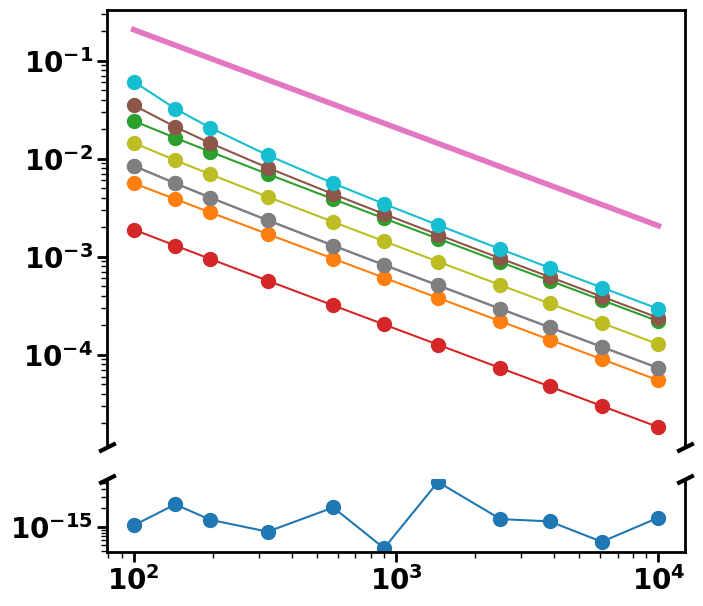

In [118]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenvalue_differences.values())).T
plot_loglog_rel_err(x, y)
plt.savefig("tiling/hexagonal_periodic/hexagonal_periodic_tiling_eigenvalue_relerr.png", dpi=200, bbox_inches='tight')

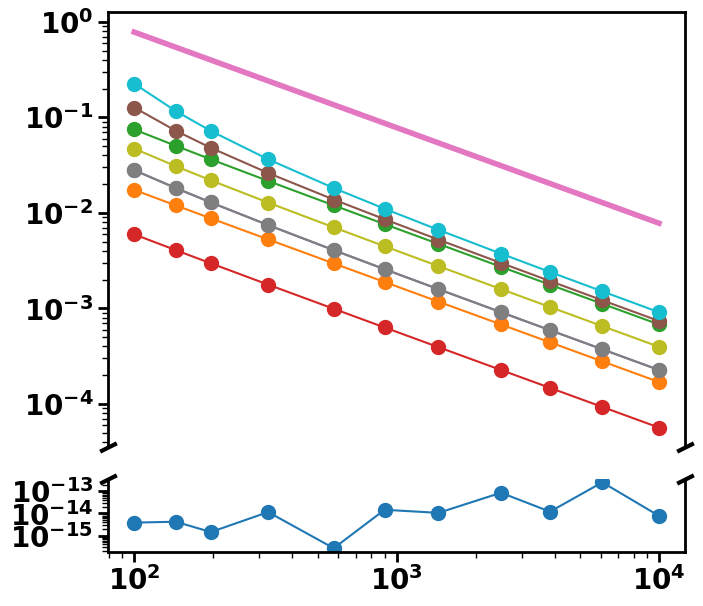

In [119]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenfunction_differences.values())).T
plot_loglog_rel_err(x, y)
plt.savefig("tiling/hexagonal_periodic/hexagonal_periodic_tiling_eigenfunction_relerr.png", dpi=200, bbox_inches='tight')

In [125]:
g = construct_graph.tiling.Tiling(tile_type='hexagonal_tile',
                                    num_horizontal_displacements=tiles_per_dim[0],
                                    num_vertical_displacements=tiles_per_dim[0],
                                    autoplot=False)
print(g.num_Vs)
p = Projector(g, eigenvalue_data[g.num_Vs])

for m, n in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    x, y, A = p.construct_pde_functions(m, n, function_domain="continuum")
    for en, a in enumerate(A):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.pcolormesh(x, y, a, cmap="plasma", shading='auto')
        style_plot(fig, ax, aspect="equal", no_ticks=True)
        ax.axis('off')
        fig.set_facecolor("black")
        plt.savefig(f"tiling/hexagonal_periodic/PDE_mode_plots/continuum_eigenmode_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
        plt.close()

100


In [127]:
g = construct_graph.tiling.Tiling(tile_type='hexagonal_tile',
                                    num_horizontal_displacements=tiles_per_dim[4],
                                    num_vertical_displacements=tiles_per_dim[4],
                                    autoplot=False)
print(g.num_Vs)

576


In [128]:
for m, n in mn:
    emodes = full_data[g.num_Vs][m, n]['graph']['eigenfunction']
    for en, emode in enumerate(emodes):
        fig, ax = g.plot_graph(eigenmode=emode.data, return_figax=True, background_color="black", linewidth=generate_graph_linewidth(g.num_Vs))
        plt.savefig(f"tiling/hexagonal_periodic/mode_plots/eigenmode_{g.num_Vs}Vs_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
        plt.close()